In [ ]:
! pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
! pip list

In [3]:
import tensorflow as tf
import os

Limiting the space used in vram so we don't get OUT of Memory Error

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
import cv2
import imghdr

In [5]:
data_dir = 'data'

In [6]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [ ]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        #How to make image paths to go through every one of them
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path) 
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list{}'.format(image_path))
                os.remove(image_path)
        except Exceptions as e:
            print('Issue with image{}'.format(image_path))
            

Load Data

In [85]:
import numpy as np
from matplotlib import pyplot as plt

In [86]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 177 files belonging to 2 classes.


In [87]:
data_iterator = data.as_numpy_iterator()

In [17]:
data_iterator

In [88]:
#Get another batch from the iterator
batch = data_iterator.next()

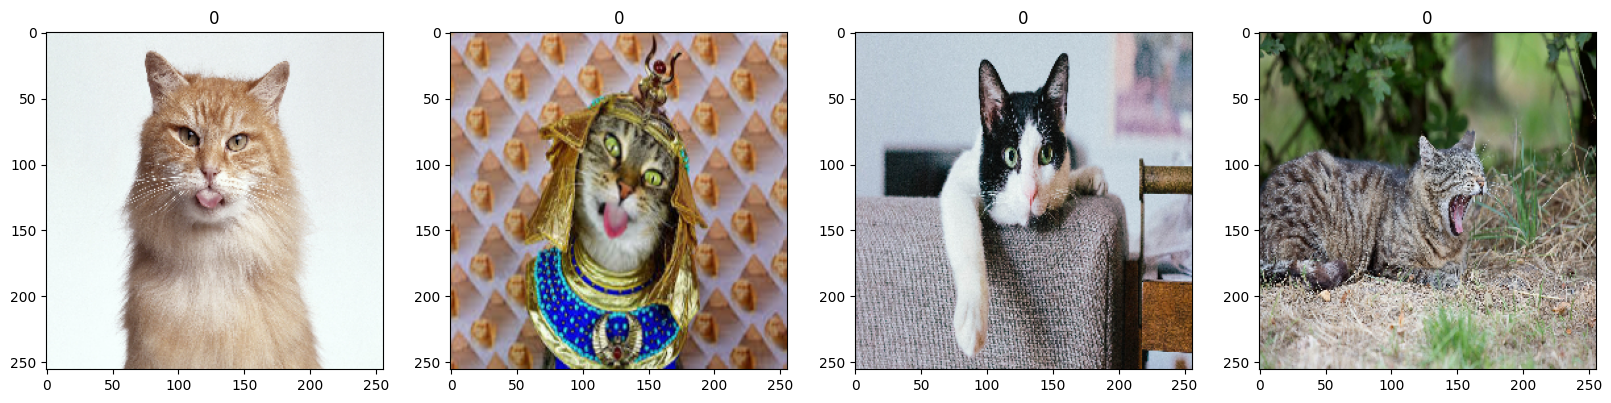

In [89]:
#checking what classes have what data?!
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [28]:
#Class 0 = Cats
#Class 1 = Dogs

PreProcessing

In [32]:
batch[0].min()
batch[0].max()

255.0

Scale Data

In [91]:
data = data.map(lambda x,y: (x/255,y))

In [93]:
scaled_iterator = data.as_numpy_iterator()

In [95]:
batch = scaled_iterator.next()

In [96]:
batch[0].max()

1.0

Split Data

In [97]:
len(data)

6

In [98]:
train_size = int(len(data)*0.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) + 1

In [99]:
test_size + train_size + val_size

6

In [100]:
#Using take and skip to create our train and test data
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [101]:
len(test)

1

Deep Model

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [103]:
#Using Sequential Model
model = Sequential()

In [104]:
#For the first layer we have to specify what is the input for our data

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape= (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [105]:
#e will use adam optimizer for this model
model.compile('adam',loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Train 

In [107]:
logdir = 'logs'

In [108]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data = val, callbacks=[tensorboard_callback]) 

In [ ]:
hist.history

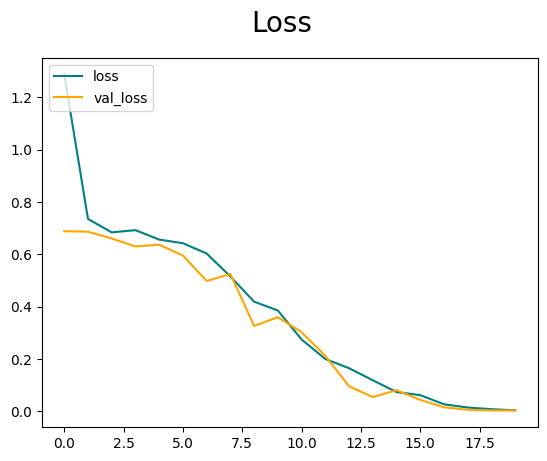

In [145]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.savefig('Loss')
plt.show()


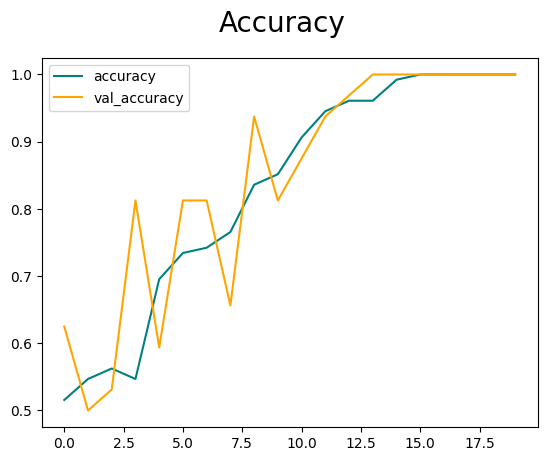

In [146]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.savefig('Accuracy')
plt.show()

Evaluate Performance

In [116]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [117]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [119]:
len(test)

1

In [121]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 458ms/step


In [122]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


Test

In [123]:
import cv2

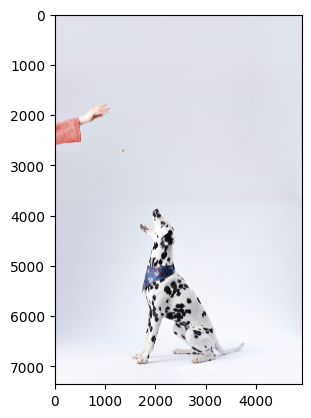

In [130]:
img = cv2.imread('dogtest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

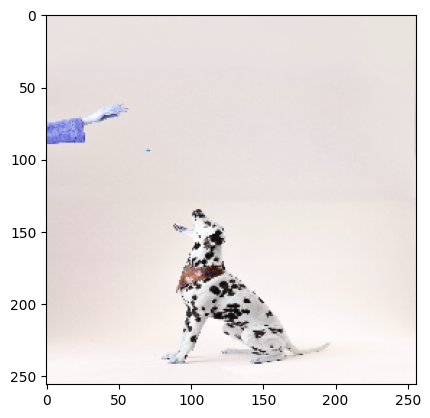

In [131]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))

In [ ]:
yhat

In [ ]:
if yhat > 0.5:
    print('That would be a Dog')
else:
    print('That is a Cat')

Save the Model

In [135]:
from tensorflow.keras.models import load_model

In [136]:
model.save(os.path.join('models','catdogmodel.h5'))

In [137]:
new_model = load_model(os.path.join('models', 'catdogmodel.h5'))

In [139]:
img = cv2.imread('dogtest.jpg')
resize = tf.image.resize(img, (256,256))

In [ ]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

In [ ]:
if yhat > 0.5:
    print('That would be a Dog')
else:
    print('That is a Cat')